In [1]:
import cv2 as cv
from glob import glob
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils
from sklearn.metrics.pairwise import cosine_similarity

% matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Training Images

In [2]:
training_images = glob('/volumes/data/images/training/*')

In [3]:
training_images

['/volumes/data/images/training/modi.jpg',
 '/volumes/data/images/training/putin.jpg']

In [4]:
def convertBGR2RGB(image):
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

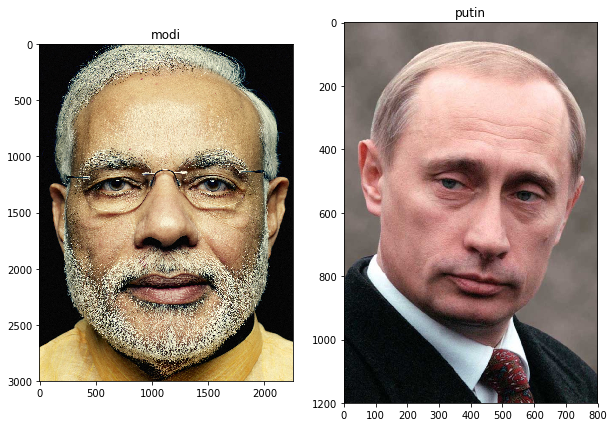

In [5]:
plt.figure(figsize=(10,10))
for ix, path in enumerate(training_images, 1):
    image = cv.imread(path)
    label = os.path.basename(path).split('.')[0]
    plt.subplot(1,2,ix)
    plt.title(label)
    plt.imshow(convertBGR2RGB(image))

### Extract feature vectors from the training images.

In [6]:
vgg_features = VGGFace(
    model='resnet50',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg')

In [7]:
def process_image(image):
    """
    This function pre-processes the passed in image to a form 
    that the `vgg_features` network expects.
    """
    img = cv.resize(image, (224, 224))
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    img = utils.preprocess_input(img, version=2)
    return img

def labels_to_images(path_to_images):
    """
    Read in the images and return a dictionary where the keys are the
    image labels and the values are the images.
    """
    files = glob(path_to_images + '/*')
    label_files = {os.path.basename(f).split('.')[0] : f for f in files}

    label_images = {label : cv.imread(path) 
            for label, path in label_files.items()}

    return label_images

def labels_to_vector(label_images):
    """
    Convert the images to feature vectors.
    """
    label_images = {label : process_image(img) 
            for label, img in label_images.items()}

    label_vector = {label : vgg_features.predict(img)
            for label, img in label_images.items()}

    return label_vector

In [8]:
label_images = labels_to_images('/volumes/data/images/training')
label_vectors = labels_to_vector(label_images)

In [9]:
label_vectors

{'modi': array([[0.        , 0.        , 0.07329664, ..., 0.        , 0.20553418,
         0.01090761]], dtype=float32),
 'putin': array([[0.66166985, 0.        , 0.        , ..., 0.12817714, 3.3082135 ,
         0.4430679 ]], dtype=float32)}

### At this point, we have read in the images from the training folder and mapped the image labels to their feature vectors.

### We will use these feature vectors to tag faces with their labels.

In [10]:
test_image = cv.imread('/volumes/data/images/world_leaders.jpg')

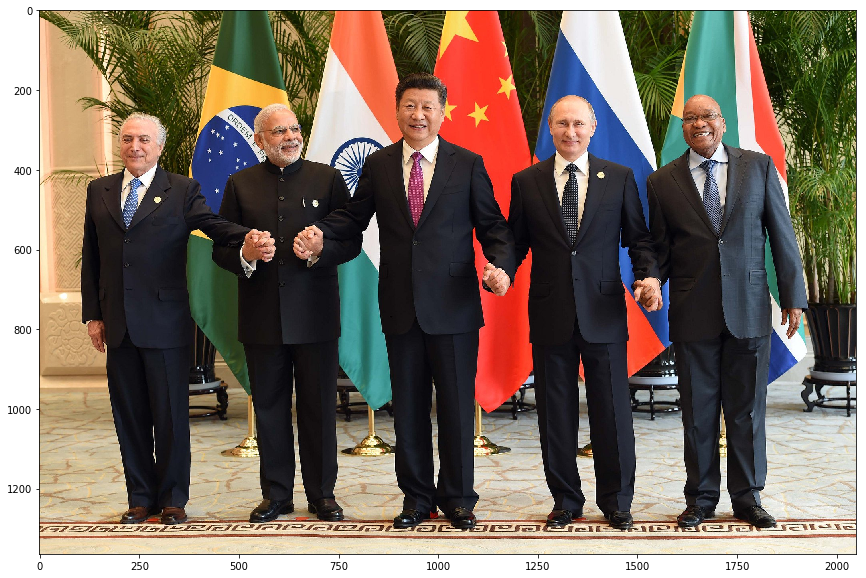

In [11]:
plt.figure(figsize=(15,10))
plt.imshow(convertBGR2RGB(test_image))

### Extract individual faces from the test image using haarcascade classifiers.

In [12]:
haar_cascade = cv.CascadeClassifier('/volumes/data/haarcascade_frontalface_alt.xml')

In [13]:
def extract_bb_faces(f_cascade, colored_img, scaleFactor=1.2):
    """
    This function takes in the haar_cascade and the image as arguments and 
    returns a dictionary with the bounding boxes of the faces as the keys and
    the face images as the values.
    """
    img_copy = colored_img.copy()
    gray = cv.cvtColor(img_copy, cv.COLOR_BGR2GRAY)          
    faces = f_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=5);          

    bb_faces = {}

    for (x, y, w, h) in faces:
        face = colored_img[y:y+h, x:x+w]
        bb_faces[(x, y, w, h)] = face

    return bb_faces

In [14]:
bb_faces = extract_bb_faces(haar_cascade, test_image)

In [15]:
def image_to_label(image, label_vectors, model):
    """
    This function takes in an image, a dictionary of labels paired with
    their feature vectors and the model with which to extract new feature vectors from.
    
    The extracted feature vectors are evaluated against the labels and their vectors
    using a metric (cosine similarity in this case) and if the vectors are sufficiently
    similar, the corresponding  label is returned.
    """
    image = process_image(image)
    feature_vector = model.predict(image)

    for label, vector in label_vectors.items():
        if cosine_similarity(feature_vector, vector) > 0.4:
            return label

    return 'UNKNOWN'

In [16]:
bb_face_labels = {bb : image_to_label(image, label_vectors, vgg_features) 
                  for bb, image in bb_faces.items()}


In [17]:
bb_face_labels

{(889, 194, 124, 124): 'UNKNOWN',
 (581, 265, 93, 93): 'modi',
 (184, 279, 116, 116): 'UNKNOWN',
 (1275, 239, 119, 119): 'putin',
 (1603, 221, 115, 115): 'UNKNOWN'}

In [18]:
test_image_copy = test_image.copy()

In [19]:
font = cv.FONT_HERSHEY_SIMPLEX

for bb, label in bb_face_labels.items():
    x, y, w, h = bb
    cv.rectangle(test_image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv.putText(test_image_copy, label, (x, y), font, 1 ,(0, 0, 255), 2, cv.LINE_AA)

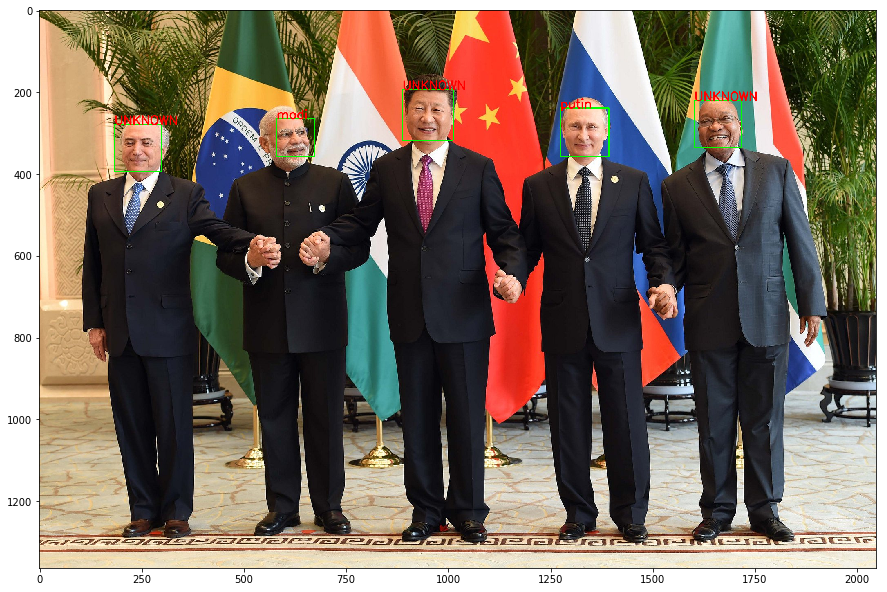

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(convertBGR2RGB(test_image_copy))